# 2D and 3D Matrix Multiplication
## Setup
### Installation
```pip install ipyparallel```

or 

```pip install -e .[notebook]```

### Start cluster

```ipcluster start -n 4 --engines=MPI --profile mpi```

In [ ]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
rc.wait_for_engines(4)
len(rc)

Waiting for connection file: ~/.ipython/profile_mpi/security/ipcontroller-client.json


KeyboardInterrupt: 

In [ ]:
%%px
import torch
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
print(f'Hello from rank {rank}!')

In [ ]:
%%px
cart_comm = comm.Create_cart(dims=[2, 2], periods=[True, True], reorder=True)
print(f'Hello from rank {rank}! My coordinates are {cart_comm.Get_coords(rank)}')


In [ ]:
%%px
print(f"Topo: {cart_comm.Get_topo()}")

In [ ]:
%%px
row_comm = cart_comm.Sub([0,1])
row_global_ranks = row_comm.allgather(rank)
print(f'Hello from rank {rank}! In my row, the ranks are {row_global_ranks}')

col_comm = cart_comm.Sub([1,0])
col_global_ranks = col_comm.allgather(rank)
print(f'Hello from rank {rank}! In my col, the ranks are {col_global_ranks}')


In [ ]:
%%px
def as_buffer(x: torch.Tensor):
    return MPI.buffer.fromaddress(x.untyped_storage().data_ptr(), 0)

## Matrix Vector

### y:= Ax

In [ ]:
%%px
A_g = torch.arange(64).reshape(8, 8)
A_l = A_g[col_comm.Get_rank()::2, row_comm.Get_rank()::2].contiguous()
print("A_local:", A_l)

x_g = torch.arange(8).reshape(8, 1)
x_l = x_g[comm.Get_rank()::comm.Get_size(), :].contiguous()
print("x_local:", x_l)


# x_col = torch.zeros(4,1, dtype=torch.long)
# col_comm.Allgather((as_buffer(x_l), 2, MPI.LONG), (as_buffer(x_col), 2, MPI.LONG))
# x_col = x_col.reshape(2,2).T.reshape(4,1).contiguous()
# print("x_gather_col:", x_col)

x_col = torch.zeros(4,1, dtype=torch.long)
data_type = MPI.LONG.Create_vector(2, 1, 2).Create_resized(MPI.LONG.Get_extent()[0], MPI.LONG.Get_extent()[1]).Commit()
col_comm.Allgather((as_buffer(x_l), 2, MPI.LONG), (as_buffer(x_col), 1, data_type))
print("x_gather_col:", x_col)

y_l = A_l @ x_col
print("y_local:", y_l)

y_l = y_l.reshape(2,2).T.reshape(4,1).contiguous()
y_scatter = torch.zeros(2, 1, dtype=torch.long)
row_comm.Reduce_scatter((as_buffer(y_l), 4, MPI.LONG), (as_buffer(y_scatter), 2, MPI.LONG), [2,2], MPI.SUM)
print("y_scatter:", y_scatter)

y_end = torch.zeros(2,2,2, dtype=torch.long)
comm.Allgather((as_buffer(y_scatter), 2, MPI.LONG), (as_buffer(y_end), 2, MPI.LONG))
y_end = y_end.permute(2,1,0).reshape(8,1).contiguous()
print("y_end:", y_end)



In [ ]:
%%px
print("Expected:", A_g @ x_g)
print("Actual:", y_end)
torch.allclose(y_end, A_g @ x_g)

### x = A.T * y

In [ ]:
%%px
A_g = torch.arange(64).reshape(8, 8)
A_l = A_g[col_comm.Get_rank()::2, row_comm.Get_rank()::2].contiguous()
print("A_local:", A_l)

y_g = torch.arange(8).reshape(8, 1)
i = col_comm.Get_rank() + col_comm.Get_size() * row_comm.Get_rank()
y_l = y_g[i::comm.Get_size(), :].contiguous()
print("y_local:", y_l)

y_col = torch.zeros(4,1, dtype=torch.long)
row_comm.Allgather((as_buffer(y_l), 2, MPI.LONG), (as_buffer(y_col), 2, MPI.LONG))
y_col = y_col.reshape(2,2).T.reshape(4,1).contiguous()
print("y_gather_col:", y_col)

x_l = A_l.T @ y_col
print("x_local:", x_l)

x_l = x_l.reshape(2,2).T.reshape(4,1).contiguous()
x_scatter = torch.zeros(2, 1, dtype=torch.long)
col_comm.Reduce_scatter((as_buffer(x_l), 4, MPI.LONG), (as_buffer(x_scatter), 2, MPI.LONG), [2,2], MPI.SUM)
print("x_scatter:", x_scatter)


In [ ]:
%%px
print("expected:", A_g.T @ y_g)

### A := y * x.T + A

In [ ]:
%%px
A_g = torch.arange(64).reshape(8, 8)
A_l = A_g[col_comm.Get_rank()::2, row_comm.Get_rank()::2].contiguous()
print("A_local:", A_l)

x_g = torch.arange(8).reshape(8, 1)
x_l = x_g[comm.Get_rank()::comm.Get_size(), :].contiguous()
print("x_local:", x_l)

y_g = torch.arange(8).reshape(8, 1)
i = col_comm.Get_rank() + col_comm.Get_size() * row_comm.Get_rank()
y_l = y_g[i::comm.Get_size(), :].contiguous()
print("y_local:", y_l)

x_col = torch.zeros(4,1, dtype=torch.long)
col_comm.Allgather((as_buffer(x_l), 2, MPI.LONG), (as_buffer(x_col), 2, MPI.LONG))
x_col = x_col.reshape(2,2).T.reshape(4,1).contiguous()
print("x_gather_col:", x_col)

y_col = torch.zeros(4,1, dtype=torch.long)
row_comm.Allgather((as_buffer(y_l), 2, MPI.LONG), (as_buffer(y_col), 2, MPI.LONG))
y_col = y_col.reshape(2,2).T.reshape(4,1).contiguous()
print("y_gather_col:", y_col)

Z_l = y_col @ x_col.T + A_l
print("Z_local:", Z_l)




In [ ]:
%%px
print(f"Expected: {y_g @ x_g.T + A_g}")

## Create_darray

In [ ]:
%%px
if comm.Get_rank() == 0:
    A = torch.arange(64).reshape(8, 8)
    print(A)
    print(A.dtype)

    darray_type = MPI.LONG.Create_darray(
        4,                    # Size
        1,                      # Rank
        # 2,                      # number of array dimensions (as well as process grid dimensions)
        [64,1],                 # size of the global array
        [MPI.DISTRIBUTE_CYCLIC, MPI.DISTRIBUTE_NONE], # distribution type
        [1, 1], # distribution argument
        [4, 1],                 # size of the process grid
        MPI.ORDER_C,            # array storage order
    ).Commit()

    # comm.Send(buf=[as_buffer(A), 8, MPI.LONG], dest=1)
    comm.Send([as_buffer(A), 1, darray_type], dest=1, tag=55)

    darray_type.Free() 

elif comm.Get_rank() == 1:
    A = torch.zeros(4, 4, dtype=torch.int64)

    # comm.Recv(buf=[as_buffer(A), 8, MPI.LONG], source=0)
    comm.Recv([as_buffer(A), 16, MPI.LONG], source=0, tag=55)
    print(A)



UsageError: Cell magic `%%px` not found.


## Large Item Count

In [ ]:
%%px
import tensorcraft as tc
comm = MPI.COMM_WORLD
## Let's find the maximum element count on my mpi implementation
options = [torch.iinfo(torch.int32).max]

for possible_max in options:
    print(f"Trying {possible_max}")
    if comm.Get_rank() == 0:
        A = torch.ones(possible_max, dtype=torch.bool)
        print(A.dtype)
        print(A[:10])

        print(f"Sending {possible_max} elements, {possible_max / 10**9} Gb")

    else:
        A = torch.zeros(possible_max, dtype=torch.bool)

    comm.Bcast(buf=[tc.mpi4torch.as_buffer(A), possible_max, MPI.BOOL], root=0)

    if comm.Get_rank() == 0:
        print("Sent!")
    else:
        print("Received!")
        print(A[:10])

# Interweave allgather

In [ ]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
rc.wait_for_engines(4)
len(rc)

4

In [ ]:
%%px
import torch
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
print(f'Hello from rank {rank}!')

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...


: 

: 

In [ ]:
%%px
import logging
import tensorcraft as tc

tc.set_logger_config(log_rank=True, level=logging.DEBUG)

x = torch.arange(40).reshape(2, 10, 2)
mesh = torch.Size([2,2])
dist = tc.mpi.MPIMultiAxisDist(mesh, (None, (0,1), None), 1)

x_local = dist.apply(x, rank)
print(x_local)
print(x_local.shape)
print(x_local.dtype)
print(x_local.is_contiguous())

%px:   0%|          | 0/4 [00:01<?, ?tasks/s]

[stdout:1] [2025-05-02 14:18:33,045][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:Processor multi index: torch.Size([0, 1])
[2025-05-02 14:18:33,047][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:Missing elements: [0, 1, 0]
[2025-05-02 14:18:33,048][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:N blocks per axis: [1, 10, 1]
[2025-05-02 14:18:33,050][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:Padded tensor shape: torch.Size([2, 11, 2])
[2025-05-02 14:18:33,054][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-05-02 14:18:33,056][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:Reshape tuple: [1, 2, 11, 1, 1, 2]
[2025-05-02 14:18:33,062][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/4:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(1), None, 4), slice(None, None, None), sl

[stdout:3] [2025-05-02 14:18:33,106][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:Processor multi index: torch.Size([1, 1])
[2025-05-02 14:18:33,108][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:Missing elements: [0, 1, 0]
[2025-05-02 14:18:33,111][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:N blocks per axis: [1, 10, 1]
[2025-05-02 14:18:33,116][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:Padded tensor shape: torch.Size([2, 11, 2])
[2025-05-02 14:18:33,122][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-05-02 14:18:33,125][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:Reshape tuple: [1, 2, 11, 1, 1, 2]
[2025-05-02 14:18:33,129][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/4:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(3), None, 4), slice(None, None, None), sl

%px:  25%|██▌       | 1/4 [00:01<00:00,  9.61tasks/s]

[stdout:0] [2025-05-02 14:18:33,146][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:Processor multi index: torch.Size([0, 0])
[2025-05-02 14:18:33,148][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:Missing elements: [0, 1, 0]
[2025-05-02 14:18:33,150][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:N blocks per axis: [1, 10, 1]
[2025-05-02 14:18:33,152][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:Padded tensor shape: torch.Size([2, 11, 2])
[2025-05-02 14:18:33,156][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-05-02 14:18:33,158][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:Reshape tuple: [1, 2, 11, 1, 1, 2]
[2025-05-02 14:18:33,162][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/4:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(0), None, 4), slice(None, None, None), sl

%px:  75%|███████▌  | 3/4 [00:01<00:00, 15.24tasks/s]

[stdout:2] [2025-05-02 14:18:33,254][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:Processor multi index: torch.Size([1, 0])
[2025-05-02 14:18:33,259][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:Missing elements: [0, 1, 0]
[2025-05-02 14:18:33,262][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:N blocks per axis: [1, 10, 1]
[2025-05-02 14:18:33,263][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:Padded tensor shape: torch.Size([2, 11, 2])
[2025-05-02 14:18:33,268][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-05-02 14:18:33,270][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:Reshape tuple: [1, 2, 11, 1, 1, 2]
[2025-05-02 14:18:33,279][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/4:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(2), None, 4), slice(None, None, None), sl

%px: 100%|██████████| 4/4 [00:01<00:00,  2.48tasks/s]


In [ ]:
%%px
new_dist, post_gather = dist.apply_allgather(x.shape, x_local, comm, gather_mesh_dim=0)
print(post_gather)

[stdout:3] [2025-05-02 14:18:33,506][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Tensor axis: 1
[2025-05-02 14:18:33,508][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mesh axis: 0
[2025-05-02 14:18:33,509][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mappings: (0, 1)
[2025-05-02 14:18:33,512][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Tensor axis: 1
[2025-05-02 14:18:33,514][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mesh axis: 0
[2025-05-02 14:18:33,515][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mappings: (0, 1)
[2025-05-02 14:18:33,522][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R3/4:New distribution: D_[2,2]⊥{∅,1,∅}(∅,1,∅), new shape: torch.Size([2, 5, 2])
[2025-05-02 14:18:33,525][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R3/4:Local tensor shape: torch.Size([2, 2, 2])
[2025-05-02 14

[stdout:0] [2025-05-02 14:18:33,505][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Tensor axis: 1
[2025-05-02 14:18:33,509][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mesh axis: 0
[2025-05-02 14:18:33,510][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mappings: (0, 1)
[2025-05-02 14:18:33,515][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Tensor axis: 1
[2025-05-02 14:18:33,518][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mesh axis: 0
[2025-05-02 14:18:33,522][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mappings: (0, 1)
[2025-05-02 14:18:33,528][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R0/4:New distribution: D_[2,2]⊥{∅,1,∅}(∅,1,∅), new shape: torch.Size([2, 5, 2])
[2025-05-02 14:18:33,535][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R0/4:Local tensor shape: torch.Size([2, 3, 2])
[2025-05-02 14

[stdout:1] [2025-05-02 14:18:33,512][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Tensor axis: 1
[2025-05-02 14:18:33,516][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mesh axis: 0
[2025-05-02 14:18:33,522][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mappings: (0, 1)
[2025-05-02 14:18:33,536][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Tensor axis: 1
[2025-05-02 14:18:33,544][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mesh axis: 0
[2025-05-02 14:18:33,553][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mappings: (0, 1)
[2025-05-02 14:18:33,565][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R1/4:New distribution: D_[2,2]⊥{∅,1,∅}(∅,1,∅), new shape: torch.Size([2, 5, 2])
[2025-05-02 14:18:33,579][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R1/4:Local tensor shape: torch.Size([2, 3, 2])
[2025-05-02 14

[stdout:2] [2025-05-02 14:18:33,526][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Tensor axis: 1
[2025-05-02 14:18:33,530][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mesh axis: 0
[2025-05-02 14:18:33,531][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mappings: (0, 1)
[2025-05-02 14:18:33,536][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Tensor axis: 1
[2025-05-02 14:18:33,544][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mesh axis: 0
[2025-05-02 14:18:33,548][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mappings: (0, 1)
[2025-05-02 14:18:33,553][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R2/4:New distribution: D_[2,2]⊥{∅,1,∅}(∅,1,∅), new shape: torch.Size([2, 5, 2])
[2025-05-02 14:18:33,558][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R2/4:Local tensor shape: torch.Size([2, 2, 2])
[2025-05-02 14

[stderr:3] /home/juanpedroghm/code/tensorcraft/tensorcraft/util/axis_utils.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_tensor = torch.tensor(index)


[stderr:1] /home/juanpedroghm/code/tensorcraft/tensorcraft/util/axis_utils.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_tensor = torch.tensor(index)


[stderr:0] /home/juanpedroghm/code/tensorcraft/tensorcraft/util/axis_utils.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_tensor = torch.tensor(index)


[stderr:2] /home/juanpedroghm/code/tensorcraft/tensorcraft/util/axis_utils.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_tensor = torch.tensor(index)


In [ ]:
%%px
post_gather

Out[2:4]: 
tensor([[[ 0,  1],
         [ 4,  5],
         [ 8,  9],
         [12, 13],
         [16, 17]],

        [[20, 21],
         [24, 25],
         [28, 29],
         [32, 33],
         [36, 37]]])

Out[0:4]: 
tensor([[[ 0,  1],
         [ 4,  5],
         [ 8,  9],
         [12, 13],
         [16, 17]],

        [[20, 21],
         [24, 25],
         [28, 29],
         [32, 33],
         [36, 37]]])

Out[1:4]: 
tensor([[[ 2,  3],
         [ 6,  7],
         [10, 11],
         [14, 15],
         [18, 19]],

        [[22, 23],
         [26, 27],
         [30, 31],
         [34, 35],
         [38, 39]]])

Out[3:4]: 
tensor([[[ 2,  3],
         [ 6,  7],
         [10, 11],
         [14, 15],
         [18, 19]],

        [[22, 23],
         [26, 27],
         [30, 31],
         [34, 35],
         [38, 39]]])

In [ ]:
%%px
new_dist, post_gather = dist.apply_allgather(x.shape, x_local, comm, gather_mesh_dim=1)
print(post_gather)

[stdout:0] [2025-05-02 14:19:16,455][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Tensor axis: 1
[2025-05-02 14:19:16,457][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mesh axis: 1
[2025-05-02 14:19:16,458][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mappings: (0, 1)
[2025-05-02 14:19:16,461][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Tensor axis: 1
[2025-05-02 14:19:16,464][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mesh axis: 1
[2025-05-02 14:19:16,465][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R0/4:Mappings: (0, 1)
[2025-05-02 14:19:16,466][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R0/4:New distribution: D_[2,2]⊥{∅,0,∅}(∅,2,∅), new shape: torch.Size([2, 6, 2])
[2025-05-02 14:19:16,467][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R0/4:Local tensor shape: torch.Size([2, 3, 2])
[2025-05-02 14

[stdout:3] [2025-05-02 14:19:16,456][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Tensor axis: 1
[2025-05-02 14:19:16,458][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mesh axis: 1
[2025-05-02 14:19:16,459][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mappings: (0, 1)
[2025-05-02 14:19:16,461][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Tensor axis: 1
[2025-05-02 14:19:16,463][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mesh axis: 1
[2025-05-02 14:19:16,464][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R3/4:Mappings: (0, 1)
[2025-05-02 14:19:16,465][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R3/4:New distribution: D_[2,2]⊥{∅,0,∅}(∅,2,∅), new shape: torch.Size([2, 4, 2])
[2025-05-02 14:19:16,467][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R3/4:Local tensor shape: torch.Size([2, 2, 2])
[2025-05-02 14

[stdout:1] [2025-05-02 14:19:16,457][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Tensor axis: 1
[2025-05-02 14:19:16,460][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mesh axis: 1
[2025-05-02 14:19:16,461][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mappings: (0, 1)
[2025-05-02 14:19:16,465][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Tensor axis: 1
[2025-05-02 14:19:16,465][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mesh axis: 1
[2025-05-02 14:19:16,465][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R1/4:Mappings: (0, 1)
[2025-05-02 14:19:16,467][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R1/4:New distribution: D_[2,2]⊥{∅,0,∅}(∅,2,∅), new shape: torch.Size([2, 6, 2])
[2025-05-02 14:19:16,468][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R1/4:Local tensor shape: torch.Size([2, 3, 2])
[2025-05-02 14

[stdout:2] [2025-05-02 14:19:16,465][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Tensor axis: 1
[2025-05-02 14:19:16,471][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mesh axis: 1
[2025-05-02 14:19:16,472][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mappings: (0, 1)
[2025-05-02 14:19:16,473][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Tensor axis: 1
[2025-05-02 14:19:16,473][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mesh axis: 1
[2025-05-02 14:19:16,474][tensorcraft.distributions.multi_axis][allgather][DEBUG] - R2/4:Mappings: (0, 1)
[2025-05-02 14:19:16,475][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R2/4:New distribution: D_[2,2]⊥{∅,0,∅}(∅,2,∅), new shape: torch.Size([2, 4, 2])
[2025-05-02 14:19:16,478][tensorcraft.mpi.distributions.multi_axis_dist][_apply_single_axis_allgather][DEBUG] - R2/4:Local tensor shape: torch.Size([2, 2, 2])
[2025-05-02 14

In [ ]:
%%px
print(post_gather)

[stdout:2] tensor([[[ 4,  5],
         [ 6,  7],
         [12, 13],
         [14, 15]],

        [[24, 25],
         [26, 27],
         [32, 33],
         [34, 35]]])


[stdout:0] tensor([[[ 0,  1],
         [ 2,  3],
         [ 8,  9],
         [10, 11],
         [16, 17],
         [18, 19]],

        [[20, 21],
         [22, 23],
         [28, 29],
         [30, 31],
         [36, 37],
         [38, 39]]])


[stdout:3] tensor([[[ 4,  5],
         [ 6,  7],
         [12, 13],
         [14, 15]],

        [[24, 25],
         [26, 27],
         [32, 33],
         [34, 35]]])


[stdout:1] tensor([[[ 0,  1],
         [ 2,  3],
         [ 8,  9],
         [10, 11],
         [16, 17],
         [18, 19]],

        [[20, 21],
         [22, 23],
         [28, 29],
         [30, 31],
         [36, 37],
         [38, 39]]])


# Permute

In [ ]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
rc.wait_for_engines(8)
len(rc)

100%|██████████| 8/8 [00:00<00:00, 22.07engine/s]


8

In [ ]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
w_size = comm.Get_size()

import torch
import logging
import tensorcraft as tc

tc.set_logger_config(log_rank=True, level=logging.DEBUG)

shape = torch.Size([2, 37, 2])
x = torch.arange(shape.numel()).reshape(shape)

mesh = torch.Size([2,2,2])
dist = tc.mpi.MPIMultiAxisDist(mesh, (None, (0,2,1), None),1)

x_local = dist.apply(x, rank)
print(x_local)
print(x_local.shape)
print(x_local.dtype)
print(x_local.is_contiguous())

%px:   0%|          | 0/8 [00:08<?, ?tasks/s]

[stdout:6] [2025-06-06 11:53:51,607][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Processor multi index: torch.Size([1, 1, 0])
[2025-06-06 11:53:51,609][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:51,610][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:51,612][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:51,615][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:51,617][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:51,620][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(5), None, 8), slice(None, None, None),

%px:  12%|█▎        | 1/8 [00:08<00:00,  8.56tasks/s]

[stdout:3] [2025-06-06 11:53:52,177][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Processor multi index: torch.Size([0, 1, 1])
[2025-06-06 11:53:52,180][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:52,181][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:52,182][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:52,186][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:52,188][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:52,192][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(3), None, 8), slice(None, None, None),

%px:  25%|██▌       | 2/8 [00:08<00:01,  3.39tasks/s]

[stdout:1] [2025-06-06 11:53:55,351][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Processor multi index: torch.Size([0, 0, 1])
[2025-06-06 11:53:55,353][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:55,355][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:55,357][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:55,360][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:55,363][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:55,368][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(2), None, 8), slice(None, None, None),

%px:  38%|███▊      | 3/8 [00:11<00:07,  1.60s/tasks]

[stdout:7] [2025-06-06 11:53:55,454][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Processor multi index: torch.Size([1, 1, 1])
[2025-06-06 11:53:55,459][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:55,465][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:55,466][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:55,475][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:55,478][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:55,485][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(7), None, 8), slice(None, None, None),

%px:  50%|█████     | 4/8 [00:12<00:04,  1.05s/tasks]

[stdout:0] [2025-06-06 11:53:56,258][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Processor multi index: torch.Size([0, 0, 0])
[2025-06-06 11:53:56,267][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:56,269][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:56,274][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:56,281][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:56,285][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:56,289][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(0), None, 8), slice(None, None, None),

%px:  62%|██████▎   | 5/8 [00:12<00:02,  1.07tasks/s]

[stdout:4] [2025-06-06 11:53:56,493][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Processor multi index: torch.Size([1, 0, 0])
[2025-06-06 11:53:56,498][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:56,499][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:56,501][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:56,506][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:56,510][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:56,518][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(4), None, 8), slice(None, None, None),

%px:  75%|███████▌  | 6/8 [00:13<00:01,  1.39tasks/s]

[stdout:5] [2025-06-06 11:53:56,980][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Processor multi index: torch.Size([1, 0, 1])
[2025-06-06 11:53:56,982][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:56,983][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:56,986][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:56,993][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:56,995][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:57,003][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(6), None, 8), slice(None, None, None),

%px:  88%|████████▊ | 7/8 [00:13<00:00,  1.62tasks/s]

[stdout:2] [2025-06-06 11:53:57,570][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Processor multi index: torch.Size([0, 1, 0])
[2025-06-06 11:53:57,571][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Missing elements: [0, 1, 0]
[2025-06-06 11:53:57,572][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:N blocks per axis: [1, 37, 1]
[2025-06-06 11:53:57,575][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 11:53:57,578][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 11:53:57,580][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 11:53:57,583][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(1), None, 8), slice(None, None, None),

%px: 100%|██████████| 8/8 [00:14<00:00,  1.76s/tasks]


In [ ]:
%%px
dist.localShape(x.shape, rank)

Out[7:2]: torch.Size([2, 4, 2])

Out[2:2]: torch.Size([2, 5, 2])

Out[3:2]: torch.Size([2, 5, 2])

Out[5:2]: torch.Size([2, 4, 2])

Out[0:2]: torch.Size([2, 5, 2])

Out[1:2]: torch.Size([2, 5, 2])

Out[4:2]: torch.Size([2, 5, 2])

Out[6:2]: torch.Size([2, 4, 2])

In [ ]:
%%px
expected_dist, _, _ = dist.permute(x.shape, mesh_dims=[0,1])
expected_dist.localShape(x.shape, rank)

Out[0:3]: torch.Size([2, 5, 2])

Out[1:3]: torch.Size([2, 5, 2])

Out[4:3]: torch.Size([2, 5, 2])

Out[7:3]: torch.Size([2, 4, 2])

Out[3:3]: torch.Size([2, 4, 2])

Out[2:3]: torch.Size([2, 5, 2])

Out[6:3]: torch.Size([2, 4, 2])

Out[5:3]: torch.Size([2, 5, 2])

In [ ]:
%%px
new_dist, new_local = dist.apply_permute(x.shape, x_local, comm, mesh_dims=[1,2])
new_local

[stdout:1] [2025-06-06 12:44:35,915][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R1/8:tensor([[[  4,   5],
         [ 20,  21],
         [ 36,  37],
         [ 52,  53],
         [ 68,  69]],

        [[ 78,  79],
         [ 94,  95],
         [110, 111],
         [126, 127],
         [142, 143]]])
[2025-06-06 12:44:35,917][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R1/8:Creating cart
[2025-06-06 12:44:36,008][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R1/8:Exchanged needed, change in virtual submesh index: 2 != 1
[2025-06-06 12:44:36,009][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R1/8:Current real idx and mindx: 1, [0, 0, 1]
[2025-06-06 12:44:36,017][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R1/8:Idx order: tensor([0, 2, 1])
[2025-06-06 12:44:36,020][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R1/8:Sub mesh dims: tensor([

[stdout:0] [2025-06-06 12:44:35,912][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R0/8:tensor([[[  0,   1],
         [ 16,  17],
         [ 32,  33],
         [ 48,  49],
         [ 64,  65]],

        [[ 74,  75],
         [ 90,  91],
         [106, 107],
         [122, 123],
         [138, 139]]])
[2025-06-06 12:44:35,917][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R0/8:Creating cart
[2025-06-06 12:44:36,006][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R0/8:0/8 - Barrier wait
[2025-06-06 12:44:36,242][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R0/8:0/8 - Barrier escape


[stdout:2] [2025-06-06 12:44:35,917][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R2/8:tensor([[[  2,   3],
         [ 18,  19],
         [ 34,  35],
         [ 50,  51],
         [ 66,  67]],

        [[ 76,  77],
         [ 92,  93],
         [108, 109],
         [124, 125],
         [140, 141]]])
[2025-06-06 12:44:35,919][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R2/8:Creating cart
[2025-06-06 12:44:36,006][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R2/8:Exchanged needed, change in virtual submesh index: 1 != 2
[2025-06-06 12:44:36,007][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R2/8:Current real idx and mindx: 2, [0, 1, 0]
[2025-06-06 12:44:36,008][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R2/8:Idx order: tensor([0, 2, 1])
[2025-06-06 12:44:36,012][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R2/8:Sub mesh dims: tensor([

[stdout:5] [2025-06-06 12:44:35,919][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R5/8:tensor([[[ 12,  13],
         [ 28,  29],
         [ 44,  45],
         [ 60,  61]],

        [[ 86,  87],
         [102, 103],
         [118, 119],
         [134, 135]]])
[2025-06-06 12:44:35,921][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R5/8:Creating cart
[2025-06-06 12:44:36,008][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R5/8:Exchanged needed, change in virtual submesh index: 6 != 5
[2025-06-06 12:44:36,009][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R5/8:Current real idx and mindx: 5, [1, 0, 1]
[2025-06-06 12:44:36,012][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R5/8:Idx order: tensor([0, 2, 1])
[2025-06-06 12:44:36,015][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R5/8:Sub mesh dims: tensor([2, 2, 2])
[2025-06-06 12:44:36,017][tensor

[stdout:4] [2025-06-06 12:44:35,926][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R4/8:tensor([[[  8,   9],
         [ 24,  25],
         [ 40,  41],
         [ 56,  57],
         [ 72,  73]],

        [[ 82,  83],
         [ 98,  99],
         [114, 115],
         [130, 131],
         [146, 147]]])
[2025-06-06 12:44:35,937][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R4/8:Creating cart
[2025-06-06 12:44:36,006][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R4/8:4/8 - Barrier wait
[2025-06-06 12:44:36,242][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R4/8:4/8 - Barrier escape


[stdout:3] [2025-06-06 12:44:35,921][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R3/8:tensor([[[  6,   7],
         [ 22,  23],
         [ 38,  39],
         [ 54,  55],
         [ 70,  71]],

        [[ 80,  81],
         [ 96,  97],
         [112, 113],
         [128, 129],
         [144, 145]]])
[2025-06-06 12:44:35,960][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R3/8:Creating cart
[2025-06-06 12:44:36,007][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R3/8:3/8 - Barrier wait
[2025-06-06 12:44:36,242][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R3/8:3/8 - Barrier escape


[stdout:7] [2025-06-06 12:44:35,939][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R7/8:tensor([[[ 14,  15],
         [ 30,  31],
         [ 46,  47],
         [ 62,  63]],

        [[ 88,  89],
         [104, 105],
         [120, 121],
         [136, 137]]])
[2025-06-06 12:44:35,971][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R7/8:Creating cart
[2025-06-06 12:44:36,008][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R7/8:7/8 - Barrier wait
[2025-06-06 12:44:36,242][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R7/8:7/8 - Barrier escape


[stdout:6] [2025-06-06 12:44:35,962][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R6/8:tensor([[[ 10,  11],
         [ 26,  27],
         [ 42,  43],
         [ 58,  59]],

        [[ 84,  85],
         [100, 101],
         [116, 117],
         [132, 133]]])
[2025-06-06 12:44:35,980][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R6/8:Creating cart
[2025-06-06 12:44:36,006][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][INFO] - R6/8:Exchanged needed, change in virtual submesh index: 5 != 6
[2025-06-06 12:44:36,020][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R6/8:Current real idx and mindx: 6, [1, 1, 0]
[2025-06-06 12:44:36,041][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R6/8:Idx order: tensor([0, 2, 1])
[2025-06-06 12:44:36,055][tensorcraft.mpi.distributions.multi_axis_dist][apply_permute][DEBUG] - R6/8:Sub mesh dims: tensor([2, 2, 2])
[2025-06-06 12:44:36,058][tensor

Out[0:11]: 
tensor([[[  0,   1],
         [ 16,  17],
         [ 32,  33],
         [ 48,  49],
         [ 64,  65]],

        [[ 74,  75],
         [ 90,  91],
         [106, 107],
         [122, 123],
         [138, 139]]])

Out[2:11]: 
tensor([[[  4,   5],
         [ 20,  21],
         [ 36,  37],
         [ 52,  53],
         [ 68,  69]],

        [[ 78,  79],
         [ 94,  95],
         [110, 111],
         [126, 127],
         [142, 143]]])

Out[6:11]: 
tensor([[[ 12,  13],
         [ 28,  29],
         [ 44,  45],
         [ 60,  61]],

        [[ 86,  87],
         [102, 103],
         [118, 119],
         [134, 135]]])

Out[1:11]: 
tensor([[[  2,   3],
         [ 18,  19],
         [ 34,  35],
         [ 50,  51],
         [ 66,  67]],

        [[ 76,  77],
         [ 92,  93],
         [108, 109],
         [124, 125],
         [140, 141]]])

Out[3:11]: 
tensor([[[  6,   7],
         [ 22,  23],
         [ 38,  39],
         [ 54,  55],
         [ 70,  71]],

        [[ 80,  81],
         [ 96,  97],
         [112, 113],
         [128, 129],
         [144, 145]]])

Out[7:11]: 
tensor([[[ 14,  15],
         [ 30,  31],
         [ 46,  47],
         [ 62,  63]],

        [[ 88,  89],
         [104, 105],
         [120, 121],
         [136, 137]]])

Out[5:11]: 
tensor([[[ 10,  11],
         [ 26,  27],
         [ 42,  43],
         [ 58,  59]],

        [[ 84,  85],
         [100, 101],
         [116, 117],
         [132, 133]]])

Out[4:11]: 
tensor([[[  8,   9],
         [ 24,  25],
         [ 40,  41],
         [ 56,  57],
         [ 72,  73]],

        [[ 82,  83],
         [ 98,  99],
         [114, 115],
         [130, 131],
         [146, 147]]])

In [ ]:
%%px
expected_local = new_dist.apply(x, rank)
torch.all(expected_local ==  new_local)
# expected_local

[stdout:0] [2025-06-06 12:44:37,393][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Processor multi index: torch.Size([0, 0, 0])
[2025-06-06 12:44:37,395][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,397][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,399][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,401][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,403][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,404][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R0/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(0), None, 8), slice(None, None, None),

[stdout:1] [2025-06-06 12:44:37,394][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Processor multi index: torch.Size([0, 0, 1])
[2025-06-06 12:44:37,398][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,402][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,404][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,406][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,406][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,408][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R1/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(1), None, 8), slice(None, None, None),

[stdout:2] [2025-06-06 12:44:37,395][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Processor multi index: torch.Size([0, 1, 0])
[2025-06-06 12:44:37,397][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,398][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,399][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,401][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,402][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,403][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R2/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(2), None, 8), slice(None, None, None),

[stdout:3] [2025-06-06 12:44:37,403][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Processor multi index: torch.Size([0, 1, 1])
[2025-06-06 12:44:37,404][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,405][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,405][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,407][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,409][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,410][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R3/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(3), None, 8), slice(None, None, None),

[stdout:4] [2025-06-06 12:44:37,404][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Processor multi index: torch.Size([1, 0, 0])
[2025-06-06 12:44:37,406][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,407][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,408][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,411][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,413][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,414][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R4/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(4), None, 8), slice(None, None, None),

[stdout:7] [2025-06-06 12:44:37,403][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Processor multi index: torch.Size([1, 1, 1])
[2025-06-06 12:44:37,408][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,409][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,409][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,411][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,418][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,419][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R7/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(7), None, 8), slice(None, None, None),

[stdout:5] [2025-06-06 12:44:37,404][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Processor multi index: torch.Size([1, 0, 1])
[2025-06-06 12:44:37,406][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,407][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,409][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,411][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,415][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,417][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R5/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(5), None, 8), slice(None, None, None),

[stdout:6] [2025-06-06 12:44:37,409][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Processor multi index: torch.Size([1, 1, 0])
[2025-06-06 12:44:37,412][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Missing elements: [0, 1, 0]
[2025-06-06 12:44:37,414][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:N blocks per axis: [1, 37, 1]
[2025-06-06 12:44:37,419][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Padded tensor shape: torch.Size([2, 38, 2])
[2025-06-06 12:44:37,422][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Permute tuple: (0, 2, 4, 1, 3, 5)
[2025-06-06 12:44:37,424][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Reshape tuple: [1, 2, 38, 1, 1, 2]
[2025-06-06 12:44:37,428][tensorcraft.mpi.distributions.multi_axis_dist][apply][DEBUG] - R6/8:Tile Slices: [slice(None, None, None), slice(None, None, None), slice(tensor(6), None, 8), slice(None, None, None),

Out[0:12]: tensor(True)

Out[3:12]: tensor(True)

Out[1:12]: tensor(True)

Out[2:12]: tensor(True)

Out[4:12]: tensor(True)

Out[7:12]: tensor(True)

Out[5:12]: tensor(True)

Out[6:12]: tensor(True)

# Alltoall

In [ ]:
import torch
import tensorcraft as tc
import logging
import matplotlib
import matplotlib.pyplot as plt
import logging
import shutil

tc.set_logger_config(level = logging.WARNING)

# LATEX_WIDTH = 517.935  # Doc
# LATEX_WIDTH = 444.14774 # Doc
LATEX_WIDTH = 370.28274 # Doc


default_figSize = tc.viz.latex2figSize(LATEX_WIDTH, fraction=1, ratio=16/9)
fontsize = 8
fontsize_small = 8

matplotlib.rcParams.update(
    {
        "figure.figsize": default_figSize,
        "figure.dpi": 200,
        "figure.autolayout": True,
        "font.family": "serif",
        "font.size": fontsize,
        "axes.labelsize": fontsize_small,
        "legend.fontsize": fontsize_small,
        "xtick.labelsize": fontsize_small,
        "ytick.labelsize": fontsize_small,
    }
)
matplotlib.rcParams['text.usetex']= True if shutil.which('latex') else False

## 4 Ranks, 2 Mesh dims
### To empty

D_[2,2]⊥{(0,1),∅}(2,∅)


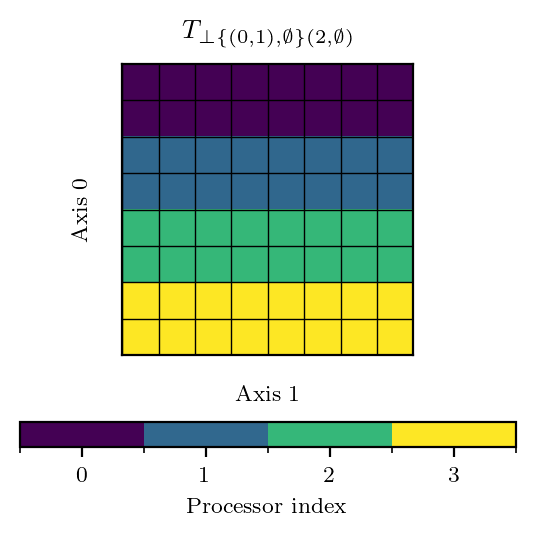

In [ ]:
tensor_shape = torch.Size([8,8])
mesh = torch.Size([2,2])
dist = tc.dist.MultiAxisDist(mesh, ((0,1), ()), 2)
print(dist)
figSize = tc.viz.latex2figSize(LATEX_WIDTH, fraction=0.5, ratio=1)
fig = plt.figure(figsize=figSize,layout='constrained')
axs = fig.add_subplot(111)
fig.suptitle(dist.latexStr())
tc.viz.draw_2d_tensor(axs, tensor_shape, dist, cbar=True)
# plt.savefig("plots/alltoall_example_start.pdf")

D_[2,2]⊥{∅,(0,1)}(∅,2)
D_[2,2]⊥{0,1}(4,2)


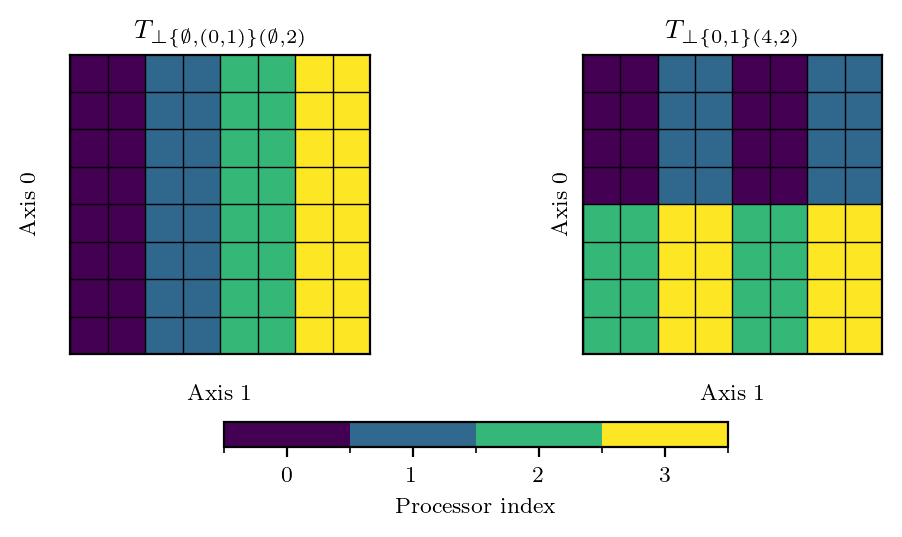

In [ ]:
figSize = tc.viz.latex2figSize(LATEX_WIDTH, fraction=1, ratio=2)
fig = plt.figure(figsize=figSize,layout='constrained')
grid = fig.add_gridspec(1, 2)
axs = grid.subplots(
    sharey=True,
)

new_dist, comm_vol, n_procs = dist.alltoall(tensor_shape, 0, 1,)
print(new_dist)
tc.viz.draw_2d_tensor(axs[0], tensor_shape, new_dist, )
axs[0].set_title(new_dist.latexStr())

new_dist, comm_vol, n_procs = dist.alltoall(tensor_shape, 0, 1, from_minor=True)
print(new_dist)
tc.viz.draw_2d_tensor(axs[1], tensor_shape, new_dist, )
axs[1].set_title(new_dist.latexStr())

tc.viz.draw_color_bar(fig, axs, tc.viz.get_n_colors(dist.numProcessors), orientation="horizontal", shrink=0.5)

In [ ]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
rc.wait_for_engines(4)
len(rc)

4

In [ ]:
%%px
from mpi4py import MPI
import torch
import tensorcraft as tc
import logging

tc.set_logger_config(level = logging.INFO)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
world_size = comm.Get_size()


global_shape = torch.Size([6,8])
global_tensor = torch.arange(global_shape.numel()).reshape(global_shape)

mesh = torch.Size([2,2])

dist = tc.mpi.MPIMultiAxisDist(mesh, ((0,1), ()), 1)
local_tensor = dist.apply(global_tensor, rank)
print(f"R{rank}/{world_size} Local tensor: {local_tensor}")


[stdout:0] R0/4 Local tensor: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [32, 33, 34, 35, 36, 37, 38, 39]])


[stdout:2] R2/4 Local tensor: tensor([[16, 17, 18, 19, 20, 21, 22, 23]])


[stdout:3] R3/4 Local tensor: tensor([[24, 25, 26, 27, 28, 29, 30, 31]])


[stdout:1] R1/4 Local tensor: tensor([[ 8,  9, 10, 11, 12, 13, 14, 15],
        [40, 41, 42, 43, 44, 45, 46, 47]])


In [ ]:
%%px
new_dist, new_l_tensor = dist.apply_alltoall(global_shape, local_tensor, comm, from_tensor_axis=0, to_tensor_axis=1, from_minor=False)
print(f"R{rank}/{world_size} Local tensor: {new_l_tensor}")

[stdout:2] R2/4 Local tensor: tensor([[16, 18, 20, 22],
        [24, 26, 28, 30]])


[stdout:3] R3/4 Local tensor: tensor([[17, 19, 21, 23],
        [25, 27, 29, 31]])


[stdout:0] R0/4 Local tensor: tensor([[ 0,  2,  4,  6],
        [ 8, 10, 12, 14],
        [32, 34, 36, 38],
        [40, 42, 44, 46]])


[stdout:1] R1/4 Local tensor: tensor([[ 1,  3,  5,  7],
        [ 9, 11, 13, 15],
        [33, 35, 37, 39],
        [41, 43, 45, 47]])
